**Team ID**: 102
    
**Members Name**
* Hailin Du, hailind2@illinois.edu
* Bo Hu, bo12@illinois.edu
* Haonan Shi, haonans4@illinois.edu

**Final Project**:
BEHRT: Transformer for Electronic Health Records

# Video Link
[Video Link](https://drive.google.com/file/d/1FYkmG-qYm0PztjwevdmEqHGVh06uyjrx/view?usp=drive_link)

# Github Repo
[Github Repo](https://github.com/persme1111/CS598-DLH-Team102.git)

# Introduction
- Model Introduction

  - The paper (BEHRT: Transformer for Electronic Health Records) introduces a deep neural sequence transduction model designed specifically for electronic health records (EHR). BEHRT can simultaneously predict the likelihood of multiple conditions in patients' future visits. BEHRT from the paper stands for BERT (Bidirectional Encoder Representations from Transformers) for EHR, which is capable of simultaneously predicting the likelihood of 301 medical conditions across future patient visits. The paper uses data from the Clinical Practice Research Datalink (CPRD), which includes records from 674 general practitioner (GP) practices in the UK. This database combines primary care data with hospital records and other health-related information, covering about 7% of the UK population, or 35 million patients. BEHRT's approach to predicting medical conditions based on patient visit sequences offers better diagnostics and personalized treatment plans.

  - To fully replicate the study, we would need access to the Clinical Practice Research Datalink (CPRD) dataset, which was very hard for student to access for studying purpose in a course. Instead, we turn to use the MIMIC-III database, which includes detailed records from over forty thousand patients who were admitted to the critical care units of Beth Israel Deaconess Medical Center between 2001 and 2012. Given the similarity of data structure between MIMIC-III and CPRD, a direct replication of the original study is possible but the performance is to be explored due to the dataset size difference. We focused on building MLM and NextXVisit to explore the BERT architecture. We applied the models to MIMIC-III data after formatting the multi-visits per patient data structure. The downstream task is to predict one individual's diagnosis code in a future visit given this individual's past visits.

- Reproducibility

   - We reproduce the original work on EHR to apply on MIMIC-III for further insight. Specifically, the original paper pre-trained masked language model and preformed a downstream fine-tuned multilabel prediction of diagnosis code given a patient's past visit. We successully apply the model architecture in BEHRT to MIMIC-III to perform multilabel prediction task and conducted ablation study in terms of the selection of model input features.

   - Firstly, we focus on cleaning the MIMIC-III dataset so that it can be used for BEHRT model. Next, we apply the model - MLM and NextXVisit - to analyze the dataset, train the model and evaluate the model using a set of evaluation metrics. Then, We rely on ablation study to understand the effect of inputs on prediction performance. Lastly, ta performance comparison between our model and the model in the original paper is discussed.

   - The core the of the reproducibility is to make sure that:
      - MIMIC-III ICD9 disease diagnosis code is used as the multilabel prediction label.
      - MIMIC-III ICD9 disease diagnosis code (originally 4000+ classes) is clinical meaningfully mapped to a much coarser category (~ 1000 classes).
      - MIMC-III data is properly preprocessed for BEHRT to be able to add position embedding and segment embedding.
      - We are able to pre-train the masked language model to learning the embedding of input features.
      - We are able to initialize the NextXVisit model parameters using the pre-trained MLM.
      - We are able to document the metrics and checkpoints during the training and evaluating process for the NextXVisit task.
      - We are able to perform ablation study to understand how each model element has an effect on model performance.

# Method


## Environment
- Python version: 3.11.5
- [Dependencies](https://github.com/persme1111/CS598-DLH-Team102/blob/main/environment.xml)





## Data
- Downloading step (MIMIC III)

  - Finish the MIMIC CITI program training provided by MIT and get the certificate ([Reference](https://piazza.com/class/lr91rjy3b7616o/post/338)):
    - [CITI Program](https://www.citiprogram.org/index.cfm?pageID=154&icat=0&ac=0). Under register, select “Massachusetts Institute of Technology Affiliate” as organization affiliation and create an account with UIUC email address.
    - Add Massachusetts Institute of Technology Affiliates course. Select the ‘’Data or Specimens Only Research’’ course.
    - Complete the course to get both certificate and report. [Apply](https://eicu-crd.mit.edu/gettingstarted/access/) for PhysioNet access.
      - Use Illinois email for PhysioNet application.
      - Mention Prof. Jimeng Sun and this course (CS 598 Deep Learning for Healthcare at UIUC) during application.
      - Upload training report.
  - Get data from Physionet ([Reference](https://piazza.com/class/lr91rjy3b7616o/post/273)):
    - Create [initial credentialed user](https://physionet.org/settings/credentialing/).
    - Complete [required training](https://physionet.org/about/citi-course/).  
    - Submit the [training completion certificate](https://physionet.org/settings/training/).
    - Sign the [data use agreement](https://physionet.org/sign-dua/mimiciii/1.4/) after receiving the confirmation.
    - [Download dataset](https://physionet.org/content/mimiciii/1.4/).
  - [Source Data](https://drive.google.com/drive/folders/1Z68xodU6IqusYJbRINw929CQ6ilOyneo?usp=sharing)
    - Note: Data above is not stored in github as the data needs appropriate access. The data in the link is only part of the whole MIMIC-III. This data link will not be shown in the github ipynb version as well for safety issue.

- Preprocessing
  - [Our Preprocessing Code](https://github.com/persme1111/CS598-DLH-Team102/blob/main/preprocess/create_a_data_set.py)
  - Dataset Size
    - The dataset we used from MIMIC-III originally has 46520 individuals.
    - We only keep the the indivuals that have enough history for prediction, i.e. requiring a minimum of 2 visits.
    - The number of individuals in the analysis reduces to N = 7526.
  - Diseases Diagnosis
    - Diseases are classified using the ICD-9 diagnosis code in MIMIC-III, which uses International Statistical Classification of Diseases and Related Health Problems (ICD) system.
    - The number of unique ICD9 code in the Dictionary of ICD9 codes is 4892.
    - We map the ICD9 code to a higher level using the function *get_ancestor* in class *pyhealth.medcode.InnerMap*.
    - This results in a total number of G = 1096 codes for diagnosis.
  -  Each patient contributes only one input-output pair to the training and evaluation process, in both pre-training MLM and fine-tuning multilabel disease prediction.
- Exploratory Data Analysis
  - After filtering for patients requiring a minimum of 2 or more visits, we have observed:
  *   The **0-9** age group shows a large decrease from 17,946 to 2,170 after filtering, indicating fewer repeat visits among younger patients.
  *   Older age groups, especially **60-69** and **70-79**, remain high even after filtering, reflecting their more frequent need for healthcare services.


| Age Group | Total Count | Count After Filter |
|-----------|-------------|--------------------|
| 0-9       | 17,946      | 2,170              |
| 10-19     | 1,748       | 152                |
| 20-29     | 13,461      | 5,247              |
| 30-39     | 20,811      | 10,323             |
| 40-49     | 47,207      | 23,557             |
| 50-59     | 87,976      | 43,612             |
| 60-69     | 118,546     | **58,101**             |
| 70-79     | **119,938**     | 54,105             |
| 80-89     | 94,832      | 38,004             |
| 90-99     | 0           | 0                  |


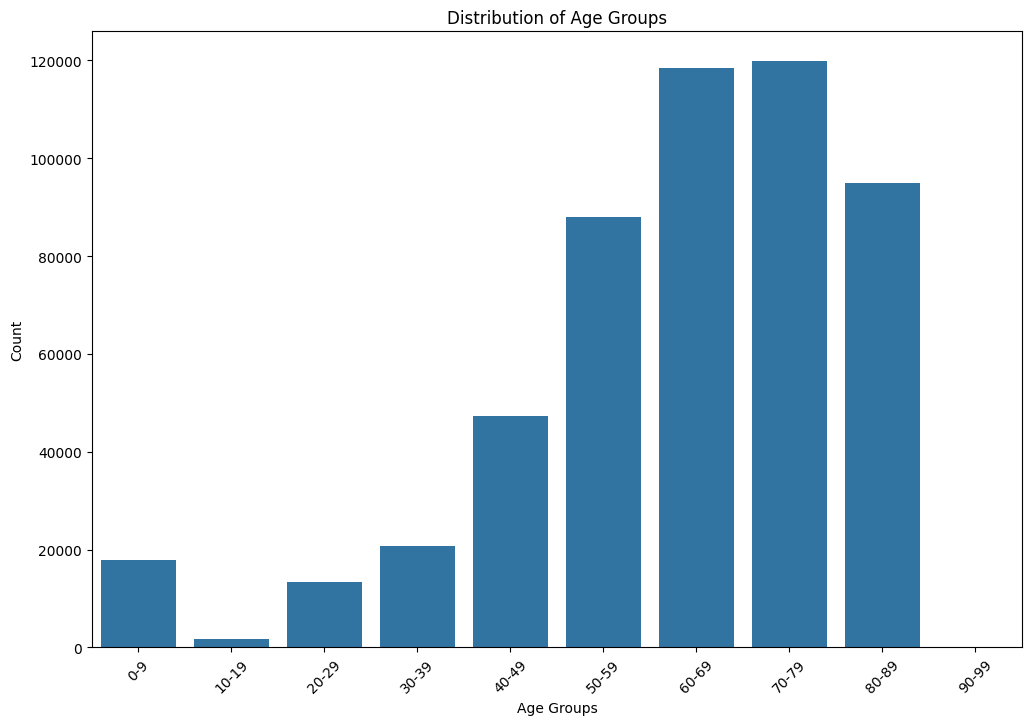



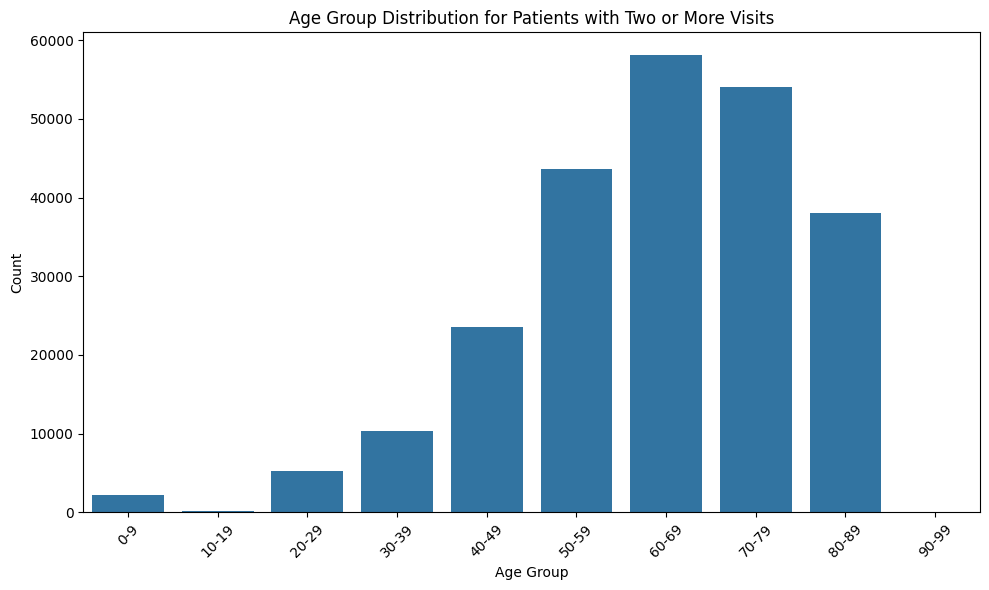

  * The top conditions like **Hypertension NOS** and **CHF NOS** remain the most prevalent even after filtering, though their counts nearly half, which reflecting significant attrition even after filter.
  * After filtering, specific conditions related to severe treatments or stages such as **Aortocoronary bypass** and **stages of chronic kidney disease** appear, indicating these are primarily associated with multiple hospital visits.

| Short Title                  | Count Before Filter | Count After Filter |
|------------------------------|---------------------|--------------------|
| Hypertension NOS             | 16,771              | 7,181              |
| CHF NOS                      | 12,418              | 6,588              |
| Atrial fibrillation          | 11,700              | 5,285              |
| Crnry athrscl natve vssl     | 10,003              | 4,183              |
| Acute kidney failure NOS     | 8,746               | 4,318              |
| DMII wo cmp nt st uncntr     | 7,997               | 3,738              |
| Hyperlipidemia NEC/NOS       | 7,789               | 3,259              |
| Acute respiratry failure     | 7,029               | 3,080              |
| Urin tract infection NOS     | 6,146               | 2,961              |
| Esophageal reflux            | 5,534               | 2,623              |
| Hypothyroidism NOS           | 4,468               | 2,230              |
| Anemia NOS                   | 4,952               | 2,186              |
| Pure hypercholesterolem      | 4,511               | 2,042              |
| Acidosis                     | 4,262               | 1,915              |
| Aortocoronary bypass         | N/A                 | 1,820              |
| Long-term use anticoagul     | 3,619               | 1,819              |
| Severe sepsis                | 3,859               | 1,796              |
| Ac posthemorrhag anemia      | 4,109               | 1,756              |
| Hyp kid NOS w cr kid V       | N/A                 | 1,750              |
| Hy kid NOS w cr kid I-IV     | N/A                 | 1,720              |


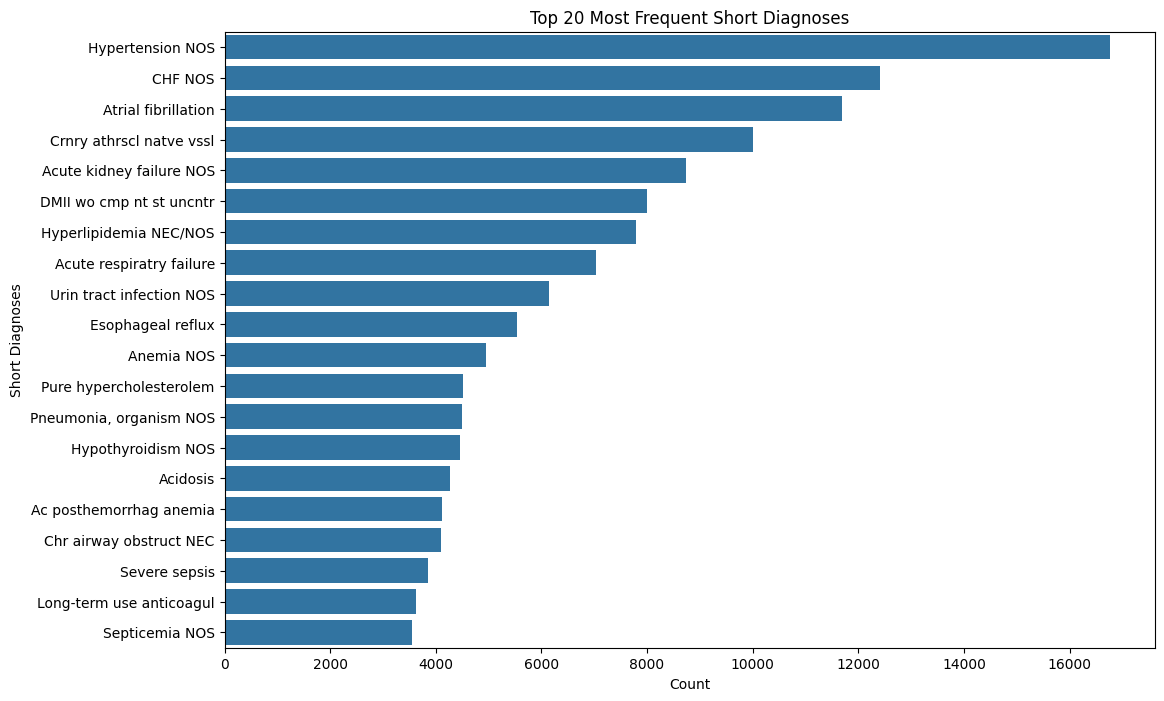

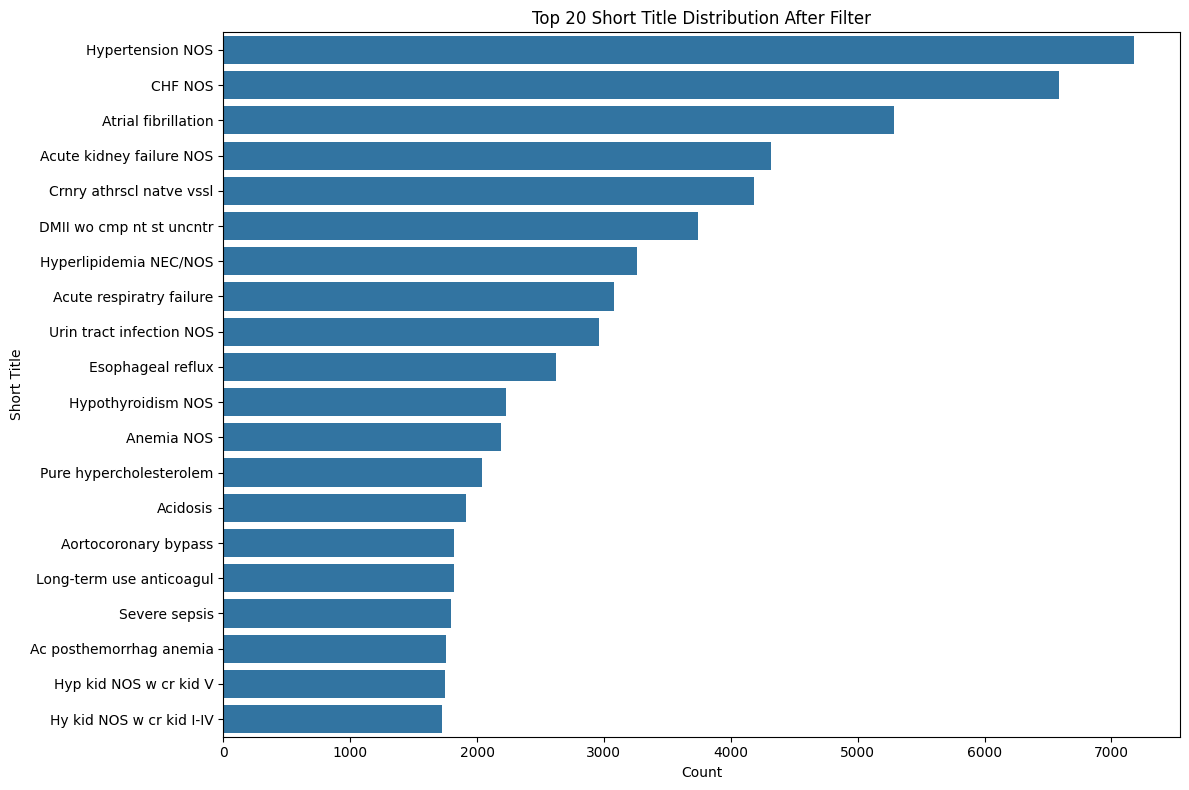

  * Significant shifts occur in the top 5 diagnoses by age group before and after the filter. For instance, less critical conditions prevalent before the filter are replaced by more severe conditions post-filter.
  * Across all age groups, there is a significant reduction in diagnosis counts after filter, reflecting a focus on patients with repeated hospital visits.
  * After filter, more severe and chronic conditions like **End stage renal disease** and **CHF NOS** become more prevalent in the top ranks, particularly in **older age groups**.

| Age Group | Diagnosis Before Filter         | Count Before Filter | Diagnosis After Filter         | Count After Filter |
|-----------|---------------------------------|---------------------|--------------------------------|--------------------|
| **0-9**   | Neonat jaund preterm del        | 1,399               | Need prphyl vc vrl hepat       | 172                |
|           | NB obsrv suspct infect          | 1,205               | Fetal/neonatal jaund NOS       | 137                |
|           | Need prphyl vc vrl hepat        | 1,098               | Single lb in-hosp w/o cs       | 129                |
|           | Respiratory distress syn        | 944                 | NB obsrv suspct infect         | 120                |
|           | Primary apnea of newborn        | 838                 | Neonat jaund preterm del       | 98                 |
| **10-19** | Lung contusion-closed           | 38                  | Asthma NOS                     | 4                  |
|           | Traum pneumothorax-close        | 26                  | Vocal cord disease NEC         | 4                  |
|           | Acute respiratry failure        | 23                  | Cerebral edema                 | 3                  |
|           | Alcohol abuse-unspec            | 20                  | Nonrupt cerebral aneurym       | 3                  |
|           | Loss control mv acc-driv        | 19                  | Pulmonary collapse             | 3                  |
| **20-29** | Acute respiratry failure        | 178                 | Acute kidney failure NOS       | 71                 |
|           | Tobacco use disorder            | 144                 | End stage renal disease        | 60                 |
|           | Acute kidney failure NOS        | 143                 | DMI ketoacd uncontrold         | 59                 |
|           | Anemia NOS                      | 142                 | Acute respiratry failure       | 53                 |
|           | Acidosis                        | 132                 | Anemia NOS                     | 53                 |
| **30-39** | Hypertension NOS                | 319                 | Hypertension NOS               | 168                |
|           | Acute respiratry failure        | 286                 | Acute kidney failure NOS       | 138                |
|           | Acute kidney failure NOS        | 269                 | Gastroparesis                  | 123                |
|           | Anemia NOS                      | 205                 | CHF NOS                        | 115                |
|           | Depressive disorder NEC         | 204                 | End stage renal disease        | 111                |
| **40-49** | Hypertension NOS                | 1,089               | Hypertension NOS               | 557                |
|           | Acute respiratry failure        | 698                 | Acute kidney failure NOS       | 350                |
|           | Acute kidney failure NOS        | 655                 | CHF NOS                        | 348                |
|           | CHF NOS                         | 584                 | Acute respiratry failure       | 312                |
|           | Tobacco use disorder            | 499                 | Esophageal reflux              | 257                |
| **50-59** | Hypertension NOS                | 2,640               | Hypertension NOS               | 1,205              |
|           | CHF NOS                         | 1,395               | CHF NOS                        | 846                |
|           | Acute kidney failure NOS        | 1,349               | Acute kidney failure NOS       | 735                |
|           | Crnry athrscl natve vssl        | 1,233               | DMII wo cmp nt st uncntr       | 581                |
|           | Acute respiratry failure        | 1,213               | Acute respiratry failure       | 570                |
| **60-69** | Hypertension NOS                | 4,019               | Hypertension NOS               | 1,774              |
|           | CHF NOS                         | 2,573               | CHF NOS                        | 1,506              |
|           | Crnry athrscl natve vssl        | 2,525               | Atrial fibrillation            | 1,168              |
|           | Atrial fibrillation             | 2,387               | Crnry athrscl natve vssl       | 1,092              |
|           | DMII wo cmp nt st uncntr        | 2,118               | DMII wo cmp nt st uncntr       | 991                |
| **70-79** | Hypertension NOS                | 4,315               | Hypertension NOS               | 1,821              |
|           | Atrial fibrillation             | 3,618               | CHF NOS                        | 1,778              |
|           | CHF NOS                         | 3,371               | Atrial fibrillation            | 1,655              |
|           | Crnry athrscl natve vssl        | 2,911               | Crnry athrscl natve vssl       | 1,183              |
|           | DMII wo cmp nt st uncntr        | 2,313               | DMII wo cmp nt st uncntr       | 1,081              |
| **80-89** | Atrial fibrillation             | 3,250               | CHF NOS                        | 1,375              |
|           | Hypertension NOS                | 3,221               | Atrial fibrillation            | 1,315              |
|           | CHF NOS                         | 3,024               | Hypertension NOS               | 1,198              |
|           | Crnry athrscl natve vssl        | 2,189               | Crnry athrscl natve vssl       | 818                |
|           | Acute kidney failure NOS        | 1,793               | Acute kidney failure NOS       | 783                |

  * The average length of stay for the **0-9** age group shows a dramatic reduction from 38.25 days to 22.79 days after applying the filter, indicating a substantial impact of the filtering criteria on younger patients.
  * Older age groups **70-79** and **80-89** demonstrate relative stability in the average length of stay, with slight increases or minimal changes after filter. This suggests that conditions treated in these age groups remain consistent in their severity or required hospitalization time.
  * For age groups ranging from **20-29** to **60-69**, the average lengths of stay show remarkable consistency before and after the filter, with minor fluctuations that indicate a stable pattern in hospital stays across these demographics.


| Age Group | Avg. Length of Stay Before Filter | Avg. Length of Stay After Filter |
|-----------|-----------------------------------|----------------------------------|
| 0-9       | 38.25                             | 22.79                            |
| 10-19     | 11.95                             | 12.45                            |
| 20-29     | 14.18                             | 13.55                            |
| 30-39     | 14.02                             | 13.50                            |
| 40-49     | 13.90                             | 13.39                            |
| 50-59     | 13.60                             | 13.88                            |
| 60-69     | 12.98                             | 13.28                            |
| 70-79     | 11.85                             | 12.28                            |
| 80-89     | 10.55                             | 10.57                            |

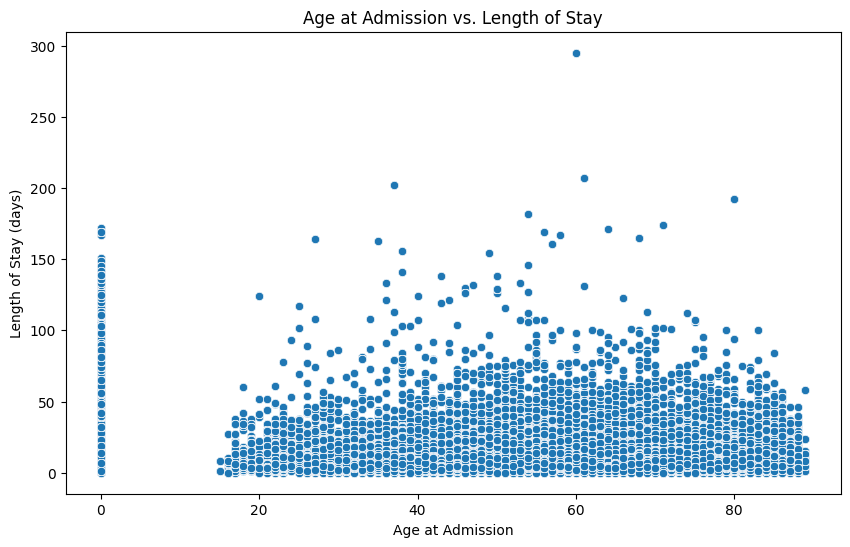

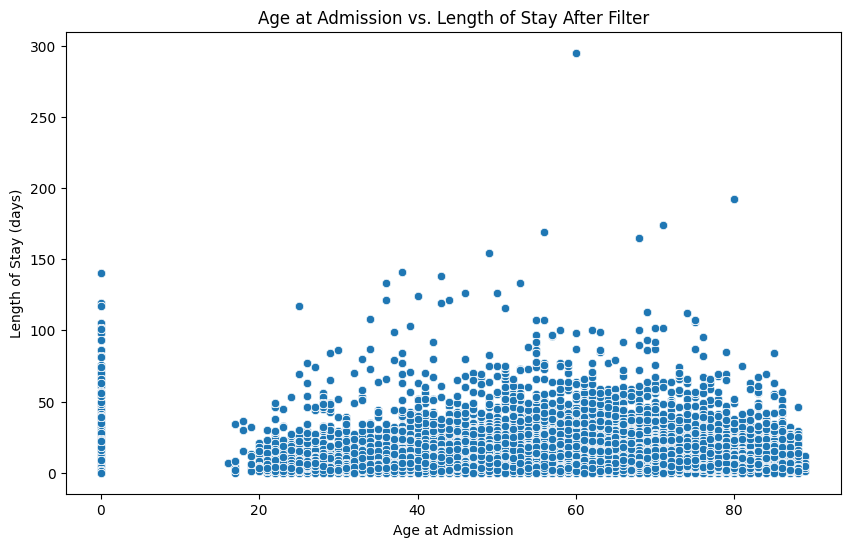


## Model
- Our project implement the [BEHRT](https://www.nature.com/articles/s41598-020-62922-y) model to MIMIC-III data as a multilabel prediction task of disease diagnosis given a history of visits.

  - [Link](https://github.com/deepmedicine/BEHRT/tree/master) to original paper's repository

  - **Reference**

    - Li, Y., Rao, S., Ayala Solares, J. R., Hassaine, A., Ramakrishnan, R., Canoy, D., Zhu, Y., Rahimi, K., & Salimi-Khorshidi, G. (2020). BEHRT: Transformer for Electronic Health Records. Scientific Reports, 10(7155). https://doi.org/10.1038/s41598-020-62922-y

- Model descprition
  - Pre-trained masked language model
    - In order to train a deep bidirectional representation of **disease code**, we simply mask some percentage of the disease code token at random, and then predict those masked tokens.

    - When training the network and specifically, the embeddings for the MLM task, we left 86.5% of the disease words unchanged; 12% of the words were replaced with [mask]; and the remaining 1.5% of words, were replaced with randomly-chosen disease words.

  - NextXVisit
    - We target to predict the diagnosis code of a patient at the next visit.
    - Due to the small dataset size, train and test are randomly split, where the test size is set at 200 and the train size has the remaining 7326.
    - We initialize model parameters using the pre-trained MLM.
    - Input data use a patient's diagnosis codes and ages at past visits, except the most recent visit.
    - Output data use a patient's diagnosis codes and age at the most recent visit.
    - We feed these input medical histories into BEHRT for feature extraction. Next, the network pools the information into a representation of the patient and passes it along to a single feed-forward classifier layer for output, subsequent visit prediction.

  - The BEHRT architecture, as the figure below shows.
      - (a) For each patient, each visit has embedding for diagnosis code, age, position and segment (alternating segment A and B). The BEHRT views the summation of all the embeddings as the latent contextual representation of one's EHR at a visit.
      - (b) The transformer based model first pre-train a masked language model to learn the embedding of disease code and a downstream multilabel prediction task fine tunes the embeddings learning in pre-trained MLM and the weights for multilabel classification task.

    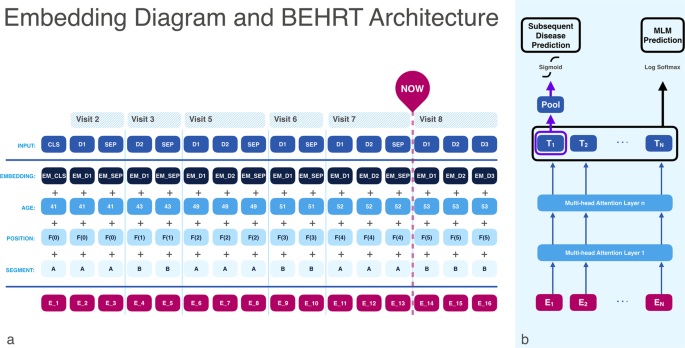
- Implementation Code
  - The model implementation code is at our project github repository: [MLM](https://github.com/persme1111/CS598-DLH-Team102/blob/main/model/MLM.py), [NextXVisit](https://github.com/persme1111/CS598-DLH-Team102/blob/main/model/NextXVisit.py)



## Training
- Hyperparameters
  - Pretrained MLM
    - mask probability
    - weight decay
    - number of epoches
    - dropout rate
  - Disease Prediction
    - hidden size
    - number of layers (transformer block)
    - number of self-attention heads
    - intermediate_size (the size of the "intermediate" layer in the transformer encoder)
- Computational requirements

  - In this project, we have Python for coding our models and analyses
pipelines. We relied on NVIDIA GeForce RTX 3090 Ti Graphical Processing Units (GPU) for pre-training, training, and testing. BertAdam is used as optimiser for both MLM and disease prediction tasks.


- The average runtime for each epoch either at MLM or NextVisit is on average 3 seconds.
- For a set of chosen hyperparameters and 50 training epoches for MLM and 100 training epoches for NextXVisit, the GPU hours is around less than 5 minutes.
- We tested around 8 trials for pre-training MLM and fine-tuning NextXVisit, both the normal study and the ablation study.





## Evaluation

- Metrics descriptions

  The evaluation metrics we used to compare true labels and predicted labels are precision score and AUROC.
  - Pre-trained MLM
    - Multilabel precision score: the ratio of true positive over predicted positive, where calculating metrics globally by counting the total true positives, false negatives and false positives over all patients and all labels.
  - Disease Prediction
    - Average porecision score: a weighted mean of precision and recall achieved at different thresholds
    - AUROC: area under the receiver operating characteristic curve
    
    We calculated the APS and AUROC for each patient first, and then averaged the resulting APS and AUROC scores across all patients.
    
- Evaluation code

  - A small portion of evaluation code is here for display purpose. For a full set of evaluation code, please refer to [the task folder](https://github.com/persme1111/CS598-DLH-Team102/tree/main/task) in github repo.


```
def precision_test(logits, label):
    sig = nn.Sigmoid()
    output=sig(logits)
    tempprc= sklearn.metrics.average_precision_score(label.numpy(),output.numpy(), average='samples')
    roc = sklearn.metrics.roc_auc_score(label.numpy(),output.numpy(), average='samples')
    return tempprc, roc, output, label

def evaluation():
    model.eval()
    y = []
    y_label = []
    tr_loss = 0
    for step, batch in enumerate(testload):
        model.eval()
        age_ids, input_ids, posi_ids, segment_ids, attMask, targets, _ = batch
        targets = torch.tensor(mlb.transform(targets.numpy()), dtype=torch.float32)
        
        age_ids = age_ids.to(global_params['device'])
        input_ids = input_ids.to(global_params['device'])
        posi_ids = posi_ids.to(global_params['device'])
        segment_ids = segment_ids.to(global_params['device'])
        attMask = attMask.to(global_params['device'])
        targets = targets.to(global_params['device'])
        
        with torch.no_grad():
            loss, logits = model(input_ids, age_ids, segment_ids, posi_ids,attention_mask=attMask, labels=targets)
        logits = logits.cpu()
        targets = targets.cpu()
        
        tr_loss += loss.item()

        y_label.append(targets)
        y.append(logits)

    y_label = torch.cat(y_label, dim=0)
    y = torch.cat(y, dim=0)

    aps, roc, output, label = precision_test(y, y_label)
    return aps, roc, tr_loss

```



# Results



## MLM Pre-training
BEHRT used Bayesian Optimization to find the optimal hyperparameters for the MLM pre-training. The main hyperparameters here are the number of layers, the number of attention heads, hidden size, and “intermediate size” – see the original BERT paper for the details. This process resulted in an optimal architecture with 6 layers, 12 attention heads, intermediate layer size of 512, and hidden size of 288. We used this set of optimal hyperparameters for our MLM and MLM ablation study (deactive age) training.

For reproduceability purposes, we trained the MLM task for 50 epochs and the model’s performance was 0.1822 in the highest precision score. We trained the MLM ablation task for 50 epochs and the model’s performance was 0.1737 in the highest precision score.

The MLM model performance is better than the MLM model performation of ablation study that deactivate age. MLM training log is available at [MLM log](https://github.com/persme1111/CS598-DLH-Team102/tree/main/modeloutput). MLM ablation study training log is available at [MLM ablation study log](https://github.com/persme1111/CS598-DLH-Team102/tree/main/modeloutput_ablation_delete_age).



## Disease Prediction

We reproduce the original work in the paper to apply BEHRT to MIMIC-III. The task is to predict the multilabel of disease diagnosis given a patient's past visits. We feed age, diagnosis code, position encoding and segment (alternating segment A and B between visits) into MLM and use the pre-training embedding to the downstream multilabel diagnosis label prediction task.

- Ablation study
  - we carried out an ablation study by deactivating age embeddings in both [MLM](https://github.com/persme1111/CS598-DLH-Team102/blob/main/task/MLM_ablation_delete_age.py) and [NEXTXVisit](https://github.com/persme1111/CS598-DLH-Team102/blob/main/task/NextXVisit_ablation_delete_age.py) and seeing their effects on precision, APS and AUROC. Results are in the following table.
---


|Model | Train: Precision | Test: Average Precision Score| Test: AUROC |
|----------|----------|----------|----------|
|   NextXVisit   |  0.2763   |   0.2855   |0.9434|
|   NextXVisit (ablation study: deactivate age)   |   0.2713  |   0.2856   |0.9437|

---



While the results are not changing significantly in terms of APS and AUROC, we see a much lower APS and AUROC at the first epoch in NextXVisit (ablation study) than in NextXVisit. Also, NextXVisit shows a slightly higher precision than NextXVisit (ablation study) in the training process. Overall, although it makes not much different in the downstream task whether add age into the model or not, it helps to understand that adding age into the model aids in learning the downstream task faster. It might be that both the position embedding and the age embedding have a similar role in providing the sequential order to the model.

Our prediction task [NextXVisit](https://github.com/persme1111/CS598-DLH-Team102/blob/main/task/NextXVisit.py) on MIMIC-III has a similar AUROC score with the task on EHR, while a much lower APS. NextXVisit on MIMIC-III is using much less dataset than the original work on EHR.

The findings in our ablation study has a similar conclusion with that in the original paper, in terms of those evaluation metrics APS and AUROC. However, the original paper provides a further discussion about the importance of age embedding in predicting certain age-related disease. Our ablation study finds out that age embedding helps to accelerate the downstream learning process.



## Disease Embedding

Given the importance of the disease embedding – resulting from training the MLM – and the effect that it can have on the overall prediction results, we first show the performance of our pre-training process, which mapped each one of the diseases to a 288-dimensional vector.

We visualize the disease bedding from the fine-tuned NextXVisit model with the full information on age, diagnosis code, position and segment. we used t-SNE to reduce the dimensionality of the disease vectors to 2 – results and demo codes are shown in the following. Based on the resulting patterns, we can see that diseases that are known to co-occur and/or belong to the same clinical groups, are grouped together. Though, dieases belong to different clinical groups might overlap due to the significant dimension reducation and limited dataset size.

The visualization implementation code is [here](https://github.com/persme1111/CS598-DLH-Team102/tree/main/visualization).

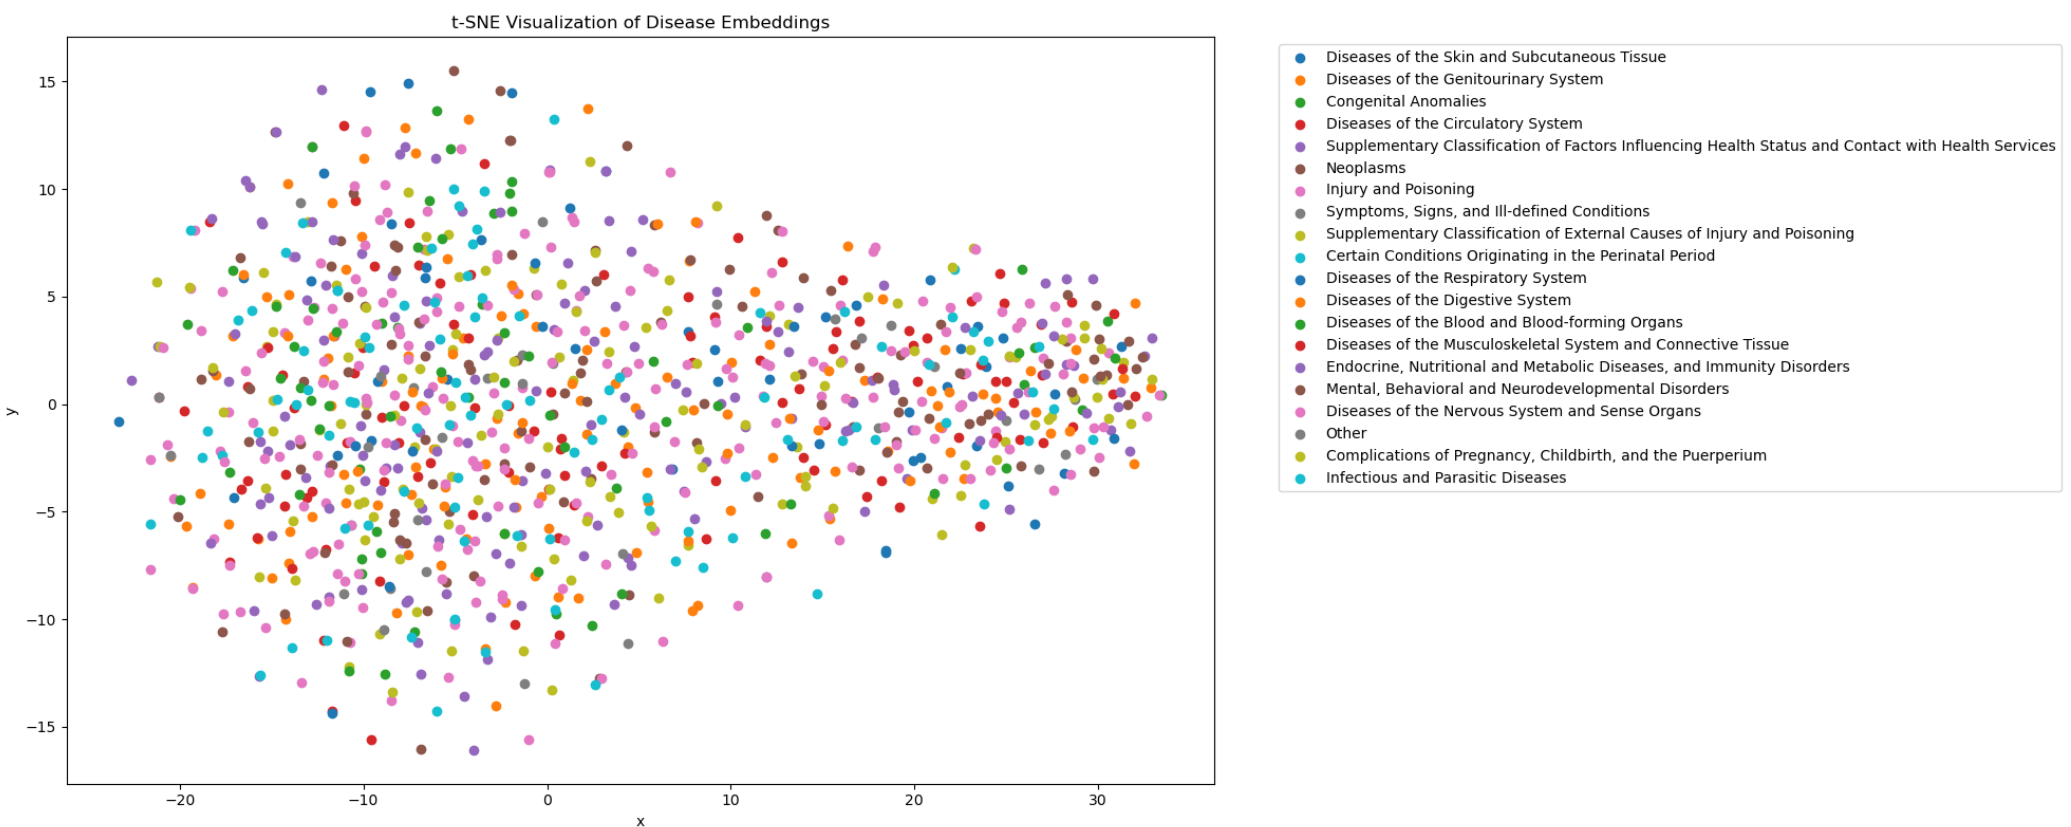

# Discussion

We are able to apply the BEHRT model on MIMIC-III to predict the next visit multilabel prediction of disease diagnosis using ICD9 code. Our model performance on MIMIC-III is similar to that of BEHRT on EHR, in terms of AUROC. However, presicion is much lower in both our MLM and our NextXVisit, comparing to BEHRT on EHR. It might be that the dataset size of MIMIC-III is around 7000, which is much smaller than the 1.6 million available patients in EHR.

Our ablation study uses less input features, i.e. deactivating age, to pre-train MLM and fine-tune NextXVisit. The ablation study result shows a consistent conclusion with the ablation study on BEHRT in EHR. The findings in our ablation study has a similar conclusion with that in the original paper, in terms of those evaluation metrics APS and AUROC. Our ablation study finds out that age embedding helps to accelerate the downstream learning process.

It was easy to build the transformer model architecture and preprocess the MIMIC-III data into a format that BEHRT requires. However, it was hard to automatically tune model hyperparameters on a large scale.

Recommendations to the original authors would be that authors could provide a wide range of applicable area where this BEHRT model can apply to.

